## Training CNN-RNN on ISOT dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
df = pd.read_csv('ISOT_clean.csv')

In [3]:
df['cleanText'] = df['cleanText'].apply(str)

Splitting data into train, validation and test set - 70/30/30 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['cleanText'], df['label'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 0.25 x 0.8 = 0.2

Using the `TextVectorization` layer to index the vocabulary found in the dataset.
Later, we'll use the same layer instance to vectorize the samples.

In [5]:
# https://keras.io/examples/nlp/pretrained_word_embeddings/
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(64)
vectorizer.adapt(text_ds)

## Load pre-trained glove word embeddings

Reference: https://nlp.stanford.edu/projects/glove/
Code Sample: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [6]:
path_to_glove_file = "../glove.6B/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Mapping glove embeddings with our vectorizer index

In [7]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
missed_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missed_words.append(word)
print("Converted %d words (%d misses)" % (hits, misses))


Converted 18916 words (1084 misses)


Words that were not preseent in the glove dictionary and will be dropped from processing.<br>
More research into preprocessing can fix some of these cases


In [8]:
len(missed_words)

1084

Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.
Note that we set `trainable=False` so as to prevent layer from updating during training

In [9]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Building the model

The model structure is replicated using https://www.sciencedirect.com/science/article/pii/S2667096820300070

#### Data Loader
Vectorizer - Converts string to sequence of word index

#### Model
Embedding Layer - Converts word index to embedded vector<br>
Conv1D          - 1D Convolution layer <br>
Max Pooling 1D  - Max pooling layer with filter size 2<br>
LSTM            - Long Short-Term Memory Network layer<br>
Dense           - Classification layer<br>

In [10]:
# https://keras.io/api/layers/recurrent_layers/lstm/

model = tf.keras.models.Sequential([
#     tf.keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.LSTM(32),#,activation=None,recurrent_activation=None),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,084,969
Trainable params: 84,769
Non-trainable params: 2,000,200
_________________________________________

## Train the model

In [11]:
# https://keras.io/examples/nlp/pretrained_word_embeddings/

x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

y_train.shape,y_val.shape

((30530,), (5388,))

In [12]:
model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
478/478 [==============================] - 59s 115ms/step - loss: 0.4044 - acc: 0.8307 - val_loss: 0.2718 - val_acc: 0.9098
Epoch 2/15
478/478 [==============================] - 66s 139ms/step - loss: 0.2367 - acc: 0.9206 - val_loss: 0.1621 - val_acc: 0.9555
Epoch 3/15
478/478 [==============================] - 96s 201ms/step - loss: 0.1044 - acc: 0.9719 - val_loss: 0.0896 - val_acc: 0.9779
Epoch 4/15
478/478 [==============================] - 94s 196ms/step - loss: 0.0370 - acc: 0.9909 - val_loss: 0.0173 - val_acc: 0.9965
Epoch 5/15
478/478 [==============================] - 99s 207ms/step - loss: 0.0188 - acc: 0.9964 - val_loss: 0.0146 - val_acc: 0.9976
Epoch 6/15
478/478 [==============================] - 98s 204ms/step - loss: 0.0138 - acc: 0.9974 - val_loss: 0.0107 - val_acc: 0.9985
Epoch 7/15
478/478 [==============================] - 98s 206ms/step - loss: 0.0114 - acc: 0.9977 - val_loss: 0.0095 - val_acc: 0.9985
Epoch 8/15
478/478 [==============================] - 9

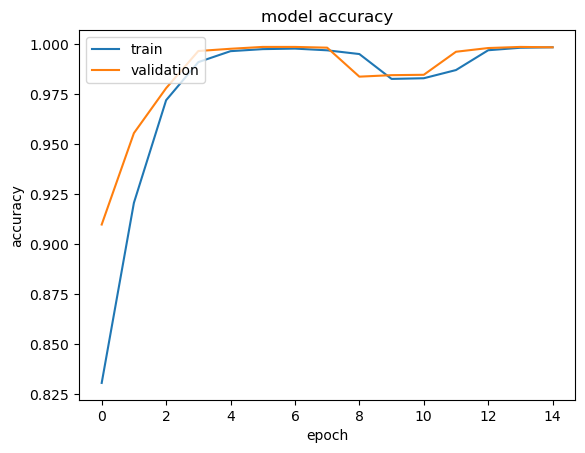

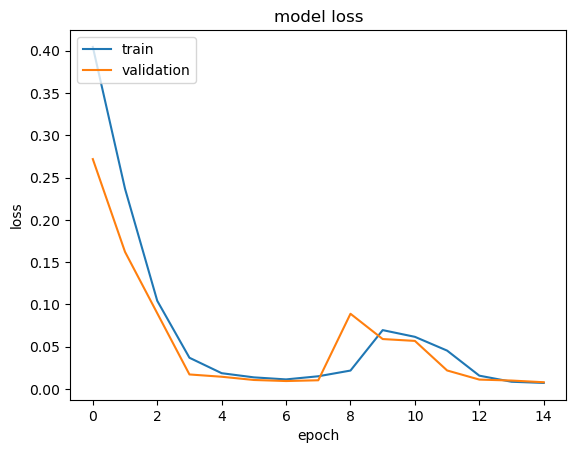

In [13]:
import matplotlib.pyplot as plt
# print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Inference on Test set

In [14]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [X_test]
)

accuracy = np.mean(np.round(probabilities.ravel()) == y_test.values)

281/281 [==============================] - 15s 50ms/step


In [15]:
print('Accuracy:',round(accuracy,2))

Accuracy: 1.0


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.round(probabilities.ravel()), zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4733
           1       1.00      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

